# Final Project - Market Indicator Machine Learning
### by Benjamin Aubry, Gary Fisher, and Bruce Mark
### - Gary's Notebook

# Import Dependencies

In [1]:
# Dependencies

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sn

import quandl
from config1 import quandl_api_key

from datetime import datetime
from datetime import date
from datetime import timedelta
from scipy.stats import linregress
from scipy.stats import zscore
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Data Extraction
### Make API Calls for Data

In [2]:
# API Calls to Quandl

# Treasury Yield Curve
try:
    treas_ylds = quandl.get("USTREASURY/YIELD", authtoken=quandl_api_key)
    treas_ylds.to_csv("quandl_data/treas_yld_curve.csv")
    print("Successfully downloaded and exported Treasury Yield Curve data")
    
except Exception as e:
    print(e)
    
# S&P 500 Monthly Dividend Yield
try:   
    sp500_div_yld = quandl.get("MULTPL/SP500_DIV_YIELD_MONTH", authtoken=quandl_api_key)
    sp500_div_yld.to_csv("quandl_data/sp500_div_yld.csv")
    print("Successfully downloaded and exported S&P 500 Monthly Dividend Yield data")
    
except Exception as e:
    print(e)   
    
# S&P 500 2-Month Futures
try:  
    sp500_2m = quandl.get("CHRIS/CME_ES2", authtoken=quandl_api_key) 
    sp500_2m.to_csv("quandl_data/sp500_2m.csv")
    print("Successfully downloaded and exported S&P 500 2-Month Futures data")

except Exception as e:
    print(e)
    
# TED Spread (3-Month LIBOR - 3-Month Treasury)
try:  
    ted_spread = quandl.get("FRED/TEDRATE", authtoken=quandl_api_key) 
    ted_spread.to_csv("quandl_data/ted_spread.csv")
    print("Successfully downloaded and exported TED Spread (3-Month LIBOR - 3-Month Treasury) data")

except Exception as e:
    print(e)

Successfully downloaded and exported Treasury Yield Curve data
Successfully downloaded and exported S&P 500 Monthly Dividend Yield data
Successfully downloaded and exported S&P 500 2-Month Futures data
Successfully downloaded and exported TED Spread (3-Month LIBOR - 3-Month Treasury) data


# Functions Used in Notebook

In [3]:
def df_datefilter(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d")):
    
    sort_dates_df = original_df.loc[(original_df["Date"] >= begin_date) & (original_df["Date"] <= end_date)]

    return sort_dates_df

In [4]:
def sp500_return(df, period=1):
    new_df = (df.shift(-period) - df) / df * 100
    return new_df

In [5]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # set com=time_window-1 to get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [6]:
def df_returns(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d"), add_text="% Ret"):
    
    sort_dates_df = original_df.loc[(original_df.index >= begin_date) & (original_df.index <= end_date)]
    
    col_titles = list(sort_dates_df)

    returns = sort_dates_df[col_titles[0]] / sort_dates_df[col_titles[0]].shift(1)-1

    perc_ret_df = pd.DataFrame({f"{col_titles[0]} {add_text}": round(returns * 100, 2)})

    for title in col_titles[1:]:
        returns = sort_dates_df[title] / sort_dates_df[title].shift(1)-1
        perc_ret_df[f"{title} {add_text}"] = round(returns * 100, 2)
    
    perc_ret_df = perc_ret_df.replace([np.inf, -np.inf], 0)
    return perc_ret_df

In [7]:
def df_corr_analysis(original_df, begin_date="1990-01-30", end_date=(date.today() - timedelta(1)).strftime("%Y-%m-%d")):
    
    sort_dates_df = original_df.loc[(original_df.index >= begin_date) & (original_df.index <= end_date)]
    
    col_titles = list(sort_dates_df)

    perc_ret_df = pd.DataFrame({f"{col_titles[0]}": sort_dates_df[col_titles[0]]})

    for title in col_titles[1:]:
        correlation = sort_dates_df[col_titles[0]].rolling(100).corr(sort_dates_df[title])
        perc_ret_df[f"{col_titles[0]} corr {title}"] = correlation

    perc_ret_df = perc_ret_df.replace([np.inf, -np.inf], 0)

    return perc_ret_df

# Data Transformation

### SP500

In [8]:
# Join SP500 2M futures with SP500 Dividend Yield
raw_sp500_df = sp500_2m[["Settle", "Open", "High", "Low", "Last"]].join(sp500_div_yld, how="outer").rename(columns={"Settle": "SP500", "Value": "Div Yld"})
raw_sp500_df.head(2)

,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1871-01-31,NaN,NaN,NaN,NaN,NaN,5.86
1871-02-28,NaN,NaN,NaN,NaN,NaN,5.78


In [9]:
# Filter to include only rows with SP500 2M futures values
filtered_sp500_df = raw_sp500_df[raw_sp500_df["SP500"].notna()].copy()
filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "1990-01-30")]
filtered_sp500_df.head(2)

,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1997-09-09,944.0,943.50,951.00,941.5,944.0,NaN
1997-09-10,925.0,942.75,943.25,917.0,925.0,NaN


### Dividend Yield

In [10]:
#Calculate Daily Dividend Yield from the monthly value

div_yield_list = []
dollar_yield_list = []

# Start =0 to avoid potential first value error in numerator
dollar_yield = 0

# Loop through rows in specific columns
for index, row in filtered_sp500_df.iterrows():
    price_row = row["SP500"]
    yield_row = row["Div Yld"]
    
    # If there is a yield value
    if yield_row > 0:
        
        # Add to dividend yield list
        div_yield_list.append(round(yield_row, 2))
        
        # Calculate the dollar yield equivalent and add to dollar yield list
        current_yield = yield_row
        dollar_yield = (current_yield / 100) * price_row
        dollar_yield_list.append(round(dollar_yield, 2))
        
    # If there is not a yield value    
    else:
        
        # Calculate the dividend yield given the stored dollar yield equivalent
        percent_yield = dollar_yield / price_row *100
        div_yield_list.append(round(percent_yield, 2))
    
print(len(div_yield_list))   


# Insert calculated dividend yields into column 
filtered_sp500_df["Div Yld"] = div_yield_list

filtered_sp500_df.head(2)

5816


,SP500,Open,High,Low,Last,Div Yld
Date,,,,,,
1997-09-09,944.0,943.50,951.00,941.5,944.0,0.0
1997-09-10,925.0,942.75,943.25,917.0,925.0,0.0


In [11]:
# Create df copy for use later in code
old_df_calcs = filtered_sp500_df.copy()

### RSI

In [12]:
# Use function to calculate RSI and insert column
filtered_sp500_df["RSI"] = computeRSI(filtered_sp500_df["SP500"], 14)
filtered_sp500_df.head(2)

,SP500,Open,High,Low,Last,Div Yld,RSI
Date,,,,,,,
1997-09-09,944.0,943.50,951.00,941.5,944.0,0.0,NaN
1997-09-10,925.0,942.75,943.25,917.0,925.0,0.0,NaN


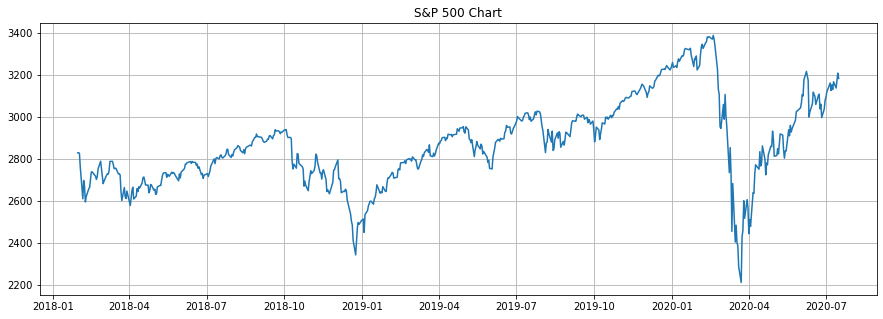

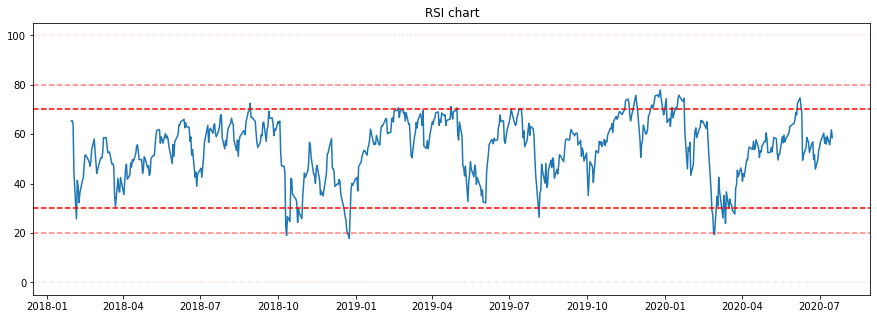

In [13]:
# Plot SP500 closing prices and RSI 

#Filter charts by date
copy_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2018-01-30")].copy()
copy_filtered_sp500_df = copy_filtered_sp500_df.reset_index()

# Plot SP500 price
plt.figure(figsize=(15,5))
plt.plot(copy_filtered_sp500_df['Date'], copy_filtered_sp500_df['SP500'])
plt.title('S&P 500 Chart')
plt.grid(alpha=1)
plt.show()

# Plot corresponding RSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(copy_filtered_sp500_df['Date'], copy_filtered_sp500_df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1, color="red")
plt.axhline(20, linestyle='--', alpha=0.5, color="red")
plt.axhline(30, linestyle='--', color="red")

plt.axhline(70, linestyle='--', color="red")
plt.axhline(80, linestyle='--', alpha=0.5, color="red")
plt.axhline(100, linestyle='--', alpha=0.1, color="red")
plt.show()

### Moving Averages

In [14]:
# Calculate different moving averages

# 12-Day Weighted Moving Average (WMA)
weights = np.arange(1,13)
filtered_sp500_df["12-DayWMA"] = filtered_sp500_df["SP500"].rolling(12).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

# 12-Day Exponential Moving Everage (EMA): 12-Day SMA is first value
sma12 = filtered_sp500_df["SP500"].rolling(window=12).mean()
modPrice12 = filtered_sp500_df["SP500"].copy()
modPrice12.iloc[0:12] = sma12[0:12]
filtered_sp500_df["12-DayEMA"] = modPrice12.ewm(span=12).mean()

# 26-Day Exponential Moving Everage (EMA): 26-Day SMA is first value
sma26 = filtered_sp500_df["SP500"].rolling(window=26).mean()
modPrice26 = filtered_sp500_df["SP500"].copy()
modPrice26.iloc[0:26] = sma26[0:26]
filtered_sp500_df["26-DayEMA"] = modPrice26.ewm(span=26).mean()

# 50, 100, and 200 Day Moving Average (SMA)
filtered_sp500_df["50-DaySMA"] = filtered_sp500_df["SP500"].rolling(window=50).mean()
filtered_sp500_df["100-DaySMA"] = filtered_sp500_df["SP500"].rolling(window=100).mean()
filtered_sp500_df["200-DaySMA"] = filtered_sp500_df["SP500"].rolling(window=200).mean()
#filtered_sp500_df["Expo20-DayMA"] = filtered_sp500_df["Last"].ewm(halflife=0.5, min_periods=20).mean()
filtered_sp500_df.head(2)

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,50-DaySMA,100-DaySMA,200-DaySMA
Date,,,,,,,,,,,,,
1997-09-09,944.0,943.50,951.00,941.5,944.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.0,942.75,943.25,917.0,925.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


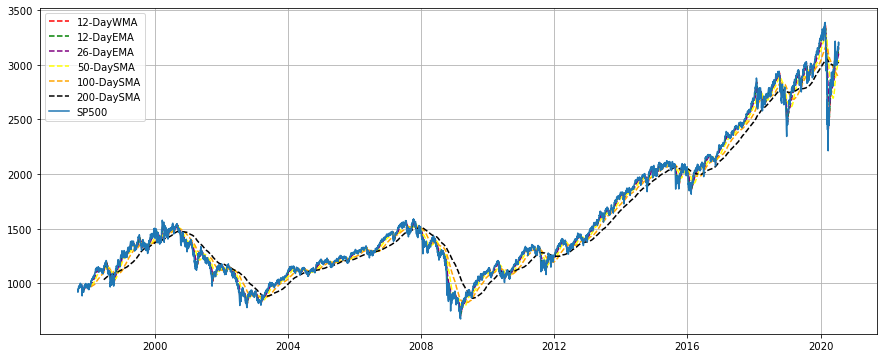

In [15]:
copysma_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "1990-01-30")].copy()
copysma_filtered_sp500_df = copysma_filtered_sp500_df#.reset_index()

plt.figure(figsize=(15,6))

plt.plot(copysma_filtered_sp500_df['12-DayWMA'], '--', label="12-DayWMA", color="red")
plt.plot(copysma_filtered_sp500_df['12-DayEMA'], '--', label="12-DayEMA", color="green")
plt.plot(copysma_filtered_sp500_df['26-DayEMA'], '--', label="26-DayEMA", color="purple")

plt.plot(copysma_filtered_sp500_df['50-DaySMA'], '--', label="50-DaySMA", color="yellow")
plt.plot(copysma_filtered_sp500_df['100-DaySMA'], '--', label="100-DaySMA", color="orange")
plt.plot(copysma_filtered_sp500_df['200-DaySMA'], '--', label="200-DaySMA", color="black")
plt.plot(copysma_filtered_sp500_df["SP500"], label="SP500")

plt.grid(alpha=1)
plt.legend()
plt.show()

In [16]:
filtered_sp500_df['3Std_Upper'] = filtered_sp500_df["SP500"].rolling(window=20).mean() + filtered_sp500_df["SP500"].rolling(window=20).std()*3
filtered_sp500_df['2Std_Upper'] = filtered_sp500_df["SP500"].rolling(window=20).mean() + filtered_sp500_df["SP500"].rolling(window=20).std()*2
filtered_sp500_df['Middle_20Day'] = filtered_sp500_df["SP500"].rolling(window=20).mean()
filtered_sp500_df['2Std_Lower'] = filtered_sp500_df["SP500"].rolling(window=20).mean() - filtered_sp500_df["SP500"].rolling(window=20).std()*2
filtered_sp500_df['3Std_Lower'] = filtered_sp500_df["SP500"].rolling(window=20).mean() - filtered_sp500_df["SP500"].rolling(window=20).std()*3
filtered_sp500_df

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,50-DaySMA,100-DaySMA,200-DaySMA,3Std_Upper,2Std_Upper,Middle_20Day,2Std_Lower,3Std_Lower
Date,,,,,,,,,,,,,,,,,,
1997-09-09,944.00,943.50,951.00,941.50,944.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.00,942.75,943.25,917.00,925.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-11,918.25,924.00,929.75,910.25,918.25,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-12,933.75,918.00,936.50,913.50,933.75,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-15,931.50,933.50,939.75,929.00,931.50,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10,3167.50,3138.00,3170.00,3101.25,3168.25,1.86,59.232743,3121.618590,3117.164110,3083.873077,3017.955,2890.6775,3020.11250,3232.181090,3185.479060,3092.0750,2998.670940,2951.968910
2020-07-13,3137.50,3171.75,3215.00,3130.00,3137.75,1.88,55.655377,3127.855769,3120.292709,3087.845442,3022.825,2888.1725,3020.85750,3232.259254,3187.427003,3097.7625,3008.097997,2963.265746
2020-07-14,3172.75,3144.00,3180.75,3108.50,3173.00,1.86,58.803720,3138.253205,3128.363061,3094.134668,3030.015,2886.2025,3021.80750,3244.213593,3197.242396,3103.3000,3009.357604,2962.386407


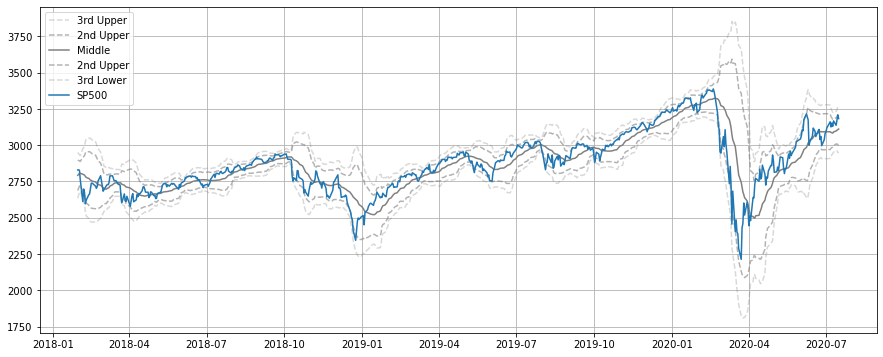

In [17]:
copyBB_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2018-01-30")].copy()
copyBB_filtered_sp500_df = copyBB_filtered_sp500_df#.reset_index()

plt.figure(figsize=(15,6))
plt.plot(copyBB_filtered_sp500_df['3Std_Upper'], '--', label="3rd Upper", color="grey", alpha=0.3)
plt.plot(copyBB_filtered_sp500_df['2Std_Upper'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(copyBB_filtered_sp500_df['Middle_20Day'], '-', label="Middle", color="grey")
plt.plot(copyBB_filtered_sp500_df['2Std_Lower'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(copyBB_filtered_sp500_df['3Std_Lower'], '--', label="3rd Lower", color="grey", alpha=0.3)
plt.plot(copyBB_filtered_sp500_df["SP500"], label="SP500")
plt.grid(alpha=1)
plt.legend()
plt.show()

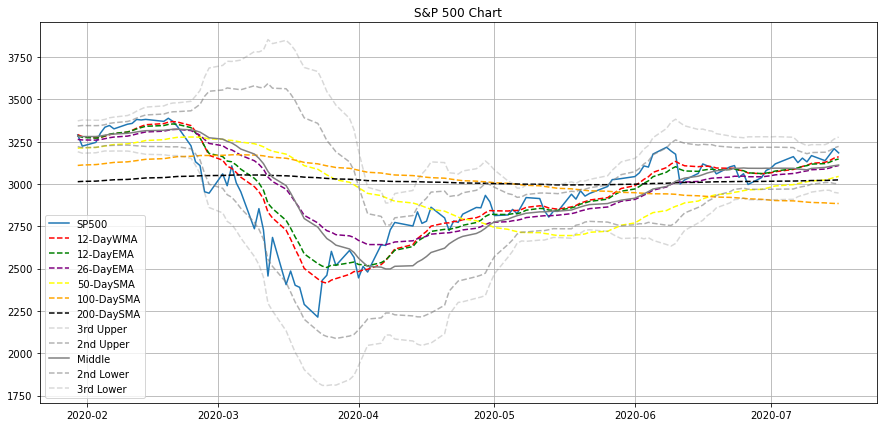

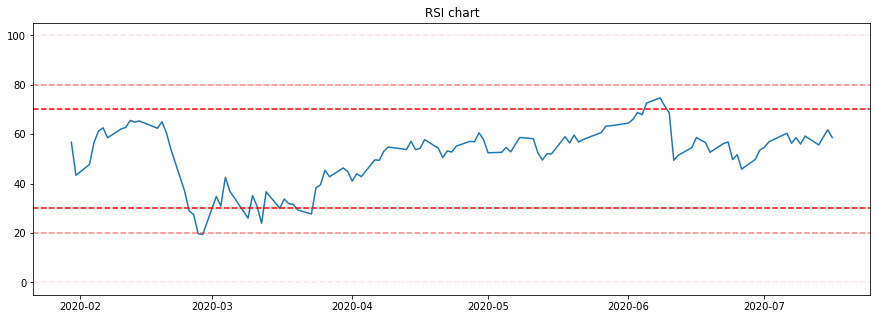

In [18]:
all_filtered_sp500_df = filtered_sp500_df.loc[(filtered_sp500_df.index >= "2020-01-30")].copy()
all_filtered_sp500_df = all_filtered_sp500_df#.reset_index()

# plot price
plt.figure(figsize=(15,7))
plt.plot(all_filtered_sp500_df['SP500'], label="SP500")
plt.plot(all_filtered_sp500_df['12-DayWMA'], '--', label="12-DayWMA", color="red")
plt.plot(all_filtered_sp500_df['12-DayEMA'], '--', label="12-DayEMA", color="green")
plt.plot(all_filtered_sp500_df['26-DayEMA'], '--', label="26-DayEMA", color="purple")
plt.plot(all_filtered_sp500_df['50-DaySMA'], '--', label="50-DaySMA", color="yellow")
plt.plot(all_filtered_sp500_df['100-DaySMA'], '--', label="100-DaySMA", color="orange")
plt.plot(all_filtered_sp500_df['200-DaySMA'], '--', label="200-DaySMA", color="black")
plt.plot(all_filtered_sp500_df['3Std_Upper'], '--', label="3rd Upper", color="grey", alpha=0.3)
plt.plot(all_filtered_sp500_df['2Std_Upper'], '--', label="2nd Upper", color="grey", alpha=0.6)
plt.plot(all_filtered_sp500_df['Middle_20Day'], '-', label="Middle", color="grey")
plt.plot(all_filtered_sp500_df['2Std_Lower'], '--', label="2nd Lower", color="grey", alpha=0.6)
plt.plot(all_filtered_sp500_df['3Std_Lower'], '--', label="3rd Lower", color="grey", alpha=0.3)
plt.title('S&P 500 Chart')
plt.grid(alpha=1)
plt.legend()
plt.show()


# plot correspondingRSI values and significant levels
plt.figure(figsize=(15,5))
plt.title('RSI chart')
plt.plot(all_filtered_sp500_df['RSI'])

plt.axhline(0, linestyle='--', alpha=0.1, color="red")
plt.axhline(20, linestyle='--', alpha=0.5, color="red")
plt.axhline(30, linestyle='--', color="red")

plt.axhline(70, linestyle='--', color="red")
plt.axhline(80, linestyle='--', alpha=0.5, color="red")
plt.axhline(100, linestyle='--', alpha=0.1, color="red")
plt.show()

In [19]:
filtered_sp500_df["12WMA%12EMA"] = (filtered_sp500_df["12-DayWMA"] - filtered_sp500_df["12-DayEMA"])/filtered_sp500_df["12-DayEMA"]*100
filtered_sp500_df["12WMA%26EMA"] = (filtered_sp500_df["12-DayWMA"] - filtered_sp500_df["26-DayEMA"])/filtered_sp500_df["26-DayEMA"]*100
filtered_sp500_df["12EMA%26EMA"] = (filtered_sp500_df["12-DayEMA"] - filtered_sp500_df["26-DayEMA"])/filtered_sp500_df["26-DayEMA"]*100

filtered_sp500_df["50SMA%100SMA"] = (filtered_sp500_df["50-DaySMA"] - filtered_sp500_df["100-DaySMA"])/filtered_sp500_df["100-DaySMA"]*100
filtered_sp500_df["50SMA%200SMA"] = (filtered_sp500_df["50-DaySMA"] - filtered_sp500_df["200-DaySMA"])/filtered_sp500_df["200-DaySMA"]*100
filtered_sp500_df["100SMA%200SMA"] = (filtered_sp500_df["100-DaySMA"] - filtered_sp500_df["200-DaySMA"])/filtered_sp500_df["200-DaySMA"]*100

filtered_sp500_df["SP500%12WMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["12-DayWMA"])/filtered_sp500_df["12-DayWMA"]*100
filtered_sp500_df["SP500%12EMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["12-DayEMA"])/filtered_sp500_df["12-DayEMA"]*100
filtered_sp500_df["SP500%26EMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["26-DayEMA"])/filtered_sp500_df["26-DayEMA"]*100

filtered_sp500_df["SP500%50SMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["50-DaySMA"])/filtered_sp500_df["50-DaySMA"]*100
filtered_sp500_df["SP500%100SMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["100-DaySMA"])/filtered_sp500_df["100-DaySMA"]*100
filtered_sp500_df["SP500%200SMA"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["200-DaySMA"])/filtered_sp500_df["200-DaySMA"]*100

filtered_sp500_df["SP500%3Upper"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["3Std_Upper"])/filtered_sp500_df["3Std_Upper"]*100
filtered_sp500_df["SP500%2Upper"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["2Std_Upper"])/filtered_sp500_df["2Std_Upper"]*100
filtered_sp500_df["SP500%Middle20Day"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["Middle_20Day"])/filtered_sp500_df["Middle_20Day"]*100
filtered_sp500_df["SP500%2Lower"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["2Std_Lower"])/filtered_sp500_df["2Std_Lower"]*100
filtered_sp500_df["SP500%3Lower"] = (filtered_sp500_df["SP500"] - filtered_sp500_df["3Std_Lower"])/filtered_sp500_df["3Std_Lower"]*100

filtered_sp500_df.head(2)

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,...,SP500%12EMA,SP500%26EMA,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower
Date,,,,,,,,,,,,,,,,,,,,,
1997-09-09,944.0,943.50,951.00,941.5,944.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.0,942.75,943.25,917.0,925.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
old_df_calcs = old_df_calcs.join(treas_ylds, how="left")
old_df_calcs = old_df_calcs[old_df_calcs["SP500"].notna()].copy()
old_df_calcs = old_df_calcs.drop(columns=["Open", "High", "Low", "Last", "1 MO", "2 MO", "1 YR", "3 YR", "5 YR", "7 YR", "20 YR", "30 YR"])

old_df_calcs["6Mo - 3Mo"] = old_df_calcs["6 MO"] - old_df_calcs["3 MO"]
old_df_calcs["SP500_Ret"] = old_df_calcs["SP500"]
old_df_calcs.head(2)

,SP500,Div Yld,3 MO,6 MO,2 YR,10 YR,6Mo - 3Mo,SP500_Ret
Date,,,,,,,,
1997-09-09,944.0,0.0,5.16,5.35,5.98,6.34,0.19,944.0
1997-09-10,925.0,0.0,5.11,5.35,6.00,6.37,0.24,925.0


In [21]:
df_calcs = df_returns(old_df_calcs)
new_calcs = df_calcs[["SP500_Ret % Ret"]].copy()
new_calcs = new_calcs.rename(columns={"SP500_Ret % Ret": "SP500 % Ret"})
new_calcs["6Mo - 3Mo % Ret"] = df_calcs["6Mo - 3Mo % Ret"]

print(new_calcs.isnull().sum())
new_calcs.dropna(inplace=True)
print(new_calcs.isnull().sum())
new_calcs.head(2)

SP500 % Ret          1
6Mo - 3Mo % Ret    232
dtype: int64
SP500 % Ret        0
6Mo - 3Mo % Ret    0
dtype: int64


,SP500 % Ret,6Mo - 3Mo % Ret
Date,,
1997-09-10,-2.01,26.32
1997-09-11,-0.73,-4.17


In [22]:
new_calcs = df_corr_analysis(new_calcs)
new_calcs["Div/10Yr-2Yr"] = old_df_calcs["Div Yld"] / (old_df_calcs["10 YR"] - old_df_calcs["2 YR"])
new_calcs = new_calcs.replace([np.inf, -np.inf], np.nan)
new_calcs.head(2)

,SP500 % Ret,SP500 % Ret corr 6Mo - 3Mo % Ret,Div/10Yr-2Yr
Date,,,
1997-09-10,-2.01,NaN,0.0
1997-09-11,-0.73,NaN,0.0


In [23]:
filtered_sp500_df["Div/10Yr-2Yr"] = new_calcs["Div/10Yr-2Yr"]
filtered_sp500_df["SP500 corr 6Mo - 3Mo % Ret"] = new_calcs["SP500 % Ret corr 6Mo - 3Mo % Ret"]
filtered_sp500_df.head(2)

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,...,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret
Date,,,,,,,,,,,,,,,,,,,,,
1997-09-09,944.0,943.50,951.00,941.5,944.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997-09-10,925.0,942.75,943.25,917.0,925.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [24]:
print(filtered_sp500_df.isnull().sum())
filtered_sp500_df.dropna(inplace=True)
print(filtered_sp500_df.isnull().sum())
filtered_sp500_df.head(2)

SP500                           0
Open                            0
High                            0
Low                             0
Last                            0
Div Yld                         0
RSI                            14
12-DayWMA                      11
12-DayEMA                      11
26-DayEMA                      25
50-DaySMA                      49
100-DaySMA                     99
200-DaySMA                    199
3Std_Upper                     19
2Std_Upper                     19
Middle_20Day                   19
2Std_Lower                     19
3Std_Lower                     19
12WMA%12EMA                    11
12WMA%26EMA                    25
12EMA%26EMA                    25
50SMA%100SMA                   99
50SMA%200SMA                  199
100SMA%200SMA                 199
SP500%12WMA                    11
SP500%12EMA                    11
SP500%26EMA                    25
SP500%50SMA                    49
SP500%100SMA                   99
SP500%200SMA  

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,...,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret
Date,,,,,,,,,,,,,,,,,,,,,
1998-06-22,1128.00,1122.5,1132.25,1122.5,1128.00,1.42,54.352587,1114.596154,1115.265675,1116.319239,...,0.504751,2.702543,9.250056,-1.887951,-0.823519,1.376173,3.675653,4.864961,-23.666667,0.035087
1998-06-23,1140.25,1130.0,1143.25,1130.0,1140.25,1.41,58.187874,1118.237179,1119.109418,1118.091891,...,1.575862,3.681005,10.331648,-1.314983,-0.131021,2.324225,4.903236,6.242116,-35.250000,0.035004


In [25]:
sp500return_df = raw_sp500_df[raw_sp500_df["SP500"].notna()].copy()
sp500return_df = sp500return_df[["SP500"]].loc[(sp500return_df.index >= "1990-01-30")]
sp500return_df.head(2)

,SP500
Date,
1997-09-09,944.0
1997-09-10,925.0


In [26]:
fwd_return = sp500_return(sp500return_df, 5)
fwd_return = fwd_return.rename(columns={"SP500": "Fwd SP500 % Ret"})
fwd_return.head(2)

,Fwd SP500 % Ret
Date,
1997-09-09,1.271186
1997-09-10,3.351351


In [27]:
print(fwd_return.isnull().sum())
fwd_return.dropna(inplace=True)
print(fwd_return.isnull().sum())
fwd_return.head(2)

Fwd SP500 % Ret    5
dtype: int64
Fwd SP500 % Ret    0
dtype: int64


,Fwd SP500 % Ret
Date,
1997-09-09,1.271186
1997-09-10,3.351351


In [28]:
master_merged_df = filtered_sp500_df.join(fwd_return, how="inner")
master_merged_df.head(2)

,SP500,Open,High,Low,Last,Div Yld,RSI,12-DayWMA,12-DayEMA,26-DayEMA,...,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret,Fwd SP500 % Ret
Date,,,,,,,,,,,,,,,,,,,,,
1998-06-22,1128.00,1122.5,1132.25,1122.5,1128.00,1.42,54.352587,1114.596154,1115.265675,1116.319239,...,2.702543,9.250056,-1.887951,-0.823519,1.376173,3.675653,4.864961,-23.666667,0.035087,3.102837
1998-06-23,1140.25,1130.0,1143.25,1130.0,1140.25,1.41,58.187874,1118.237179,1119.109418,1118.091891,...,3.681005,10.331648,-1.314983,-0.131021,2.324225,4.903236,6.242116,-35.250000,0.035004,1.468976


In [29]:
list(master_merged_df)

['SP500',
 'Open',
 'High',
 'Low',
 'Last',
 'Div Yld',
 'RSI',
 '12-DayWMA',
 '12-DayEMA',
 '26-DayEMA',
 '50-DaySMA',
 '100-DaySMA',
 '200-DaySMA',
 '3Std_Upper',
 '2Std_Upper',
 'Middle_20Day',
 '2Std_Lower',
 '3Std_Lower',
 '12WMA%12EMA',
 '12WMA%26EMA',
 '12EMA%26EMA',
 '50SMA%100SMA',
 '50SMA%200SMA',
 '100SMA%200SMA',
 'SP500%12WMA',
 'SP500%12EMA',
 'SP500%26EMA',
 'SP500%50SMA',
 'SP500%100SMA',
 'SP500%200SMA',
 'SP500%3Upper',
 'SP500%2Upper',
 'SP500%Middle20Day',
 'SP500%2Lower',
 'SP500%3Lower',
 'Div/10Yr-2Yr',
 'SP500 corr 6Mo - 3Mo % Ret',
 'Fwd SP500 % Ret']

In [30]:
master_merged_df = master_merged_df.drop(columns=['SP500',
                                                  'Open', 
                                                  'High',
                                                  'Low',
                                                  'Last',
                                                  'Div Yld',
                                                  '12-DayWMA',
                                                  '12-DayEMA',
                                                  '26-DayEMA',
                                                  '50-DaySMA',
                                                  '100-DaySMA',
                                                  '200-DaySMA',
                                                  '3Std_Upper',
                                                  '2Std_Upper',
                                                  'Middle_20Day',
                                                  '2Std_Lower',
                                                  '3Std_Lower',
                                                 ])
master_merged_df.head(2)

,RSI,12WMA%12EMA,12WMA%26EMA,12EMA%26EMA,50SMA%100SMA,50SMA%200SMA,100SMA%200SMA,SP500%12WMA,SP500%12EMA,SP500%26EMA,...,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret,Fwd SP500 % Ret
Date,,,,,,,,,,,,,,,,,,,,,
1998-06-22,54.352587,-0.060032,-0.154354,-0.094378,2.186754,8.701384,6.375220,1.202574,1.141820,1.046364,...,2.702543,9.250056,-1.887951,-0.823519,1.376173,3.675653,4.864961,-23.666667,0.035087,3.102837
1998-06-23,58.187874,-0.077940,0.012994,0.091006,2.072484,8.619947,6.414524,1.968529,1.889054,1.981779,...,3.681005,10.331648,-1.314983,-0.131021,2.324225,4.903236,6.242116,-35.250000,0.035004,1.468976


In [31]:
training_master_df = master_merged_df.reset_index().copy()
training_master_df = df_datefilter(training_master_df, end_date="2016-01-29")
print(f"Training Start Date: {training_master_df.Date[0]}")
print(f"Training End Date: {training_master_df.Date[len(training_master_df)-1]}")
training_master_df = training_master_df.drop(columns=['Date'])

#Export to CSV
training_master_df.to_csv("quandl_data/training_data_gary.csv", encoding='utf-8')
training_master_df

Training Start Date: 1998-06-22 00:00:00
Training End Date: 2016-01-29 00:00:00


,RSI,12WMA%12EMA,12WMA%26EMA,12EMA%26EMA,50SMA%100SMA,50SMA%200SMA,100SMA%200SMA,SP500%12WMA,SP500%12EMA,SP500%26EMA,...,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret,Fwd SP500 % Ret
0,54.352587,-0.060032,-0.154354,-0.094378,2.186754,8.701384,6.375220,1.202574,1.141820,1.046364,...,2.702543,9.250056,-1.887951,-0.823519,1.376173,3.675653,4.864961,-23.666667,0.035087,3.102837
1,58.187874,-0.077940,0.012994,0.091006,2.072484,8.619947,6.414524,1.968529,1.889054,1.981779,...,3.681005,10.331648,-1.314983,-0.131021,2.324225,4.903236,6.242116,-35.250000,0.035004,1.468976
2,62.042890,-0.055834,0.276386,0.332406,1.978627,8.535501,6.429655,2.682801,2.625469,2.966602,...,4.800242,11.538536,-0.969337,0.429224,3.348297,6.442141,8.059582,-46.333333,0.038370,1.386482
3,61.378060,0.011647,0.517886,0.506180,1.881923,8.439804,6.436746,2.088734,2.100624,2.617437,...,4.538703,11.267594,-1.726144,-0.194098,3.017911,6.443535,8.243226,-19.857143,0.041260,1.084599
4,63.748642,0.113890,0.810422,0.695739,1.815670,8.388002,6.455128,2.287572,2.404067,3.116532,...,5.176143,11.965398,-1.765028,-0.056179,3.546305,7.418204,9.464808,-27.600000,0.043665,1.550388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,35.813684,-1.078154,-3.397296,-2.344418,0.504575,-1.459228,-1.953944,-0.678902,-1.749736,-4.053133,...,-6.747532,-8.569633,-14.212109,-11.089733,-4.109589,4.059920,8.689910,2.000000,-0.000090,3.276047
4274,41.122855,-0.996950,-3.180633,-2.205672,0.339839,-1.581966,-1.915296,0.672600,-0.331056,-2.529426,...,-5.448690,-7.259627,-12.330991,-9.250081,-2.389524,5.593159,10.094999,1.956897,-0.011318,0.066216
4275,38.368709,-0.900782,-3.040674,-2.159342,0.209062,-1.694122,-1.899213,-0.311812,-1.209786,-3.343005,...,-6.454607,-8.231233,-12.545034,-9.585839,-3.023063,4.567009,8.825727,1.940678,-0.018775,1.754151
4276,39.524847,-0.812140,-2.871083,-2.075802,0.102497,-1.779588,-1.880158,0.033903,-0.778512,-2.838154,...,-6.148583,-7.913138,-10.936613,-8.216527,-2.245483,4.556523,8.325296,1.957265,-0.021283,1.415220


In [32]:
testing_master_df = master_merged_df.reset_index().copy()
testing_master_df = df_datefilter(testing_master_df, begin_date="2016-01-30").reset_index()
print(f"Testing Start Date: {testing_master_df.Date[0]}")
print(f"Testing End Date: {testing_master_df.Date[len(testing_master_df)-1]}")
testing_master_df = testing_master_df.drop(columns=['index','Date'])

#Export to CSV
testing_master_df.to_csv("quandl_data/testing_data_gary.csv", encoding='utf-8')
testing_master_df

Testing Start Date: 2016-02-01 00:00:00
Testing End Date: 2020-07-09 00:00:00


,RSI,12WMA%12EMA,12WMA%26EMA,12EMA%26EMA,50SMA%100SMA,50SMA%200SMA,100SMA%200SMA,SP500%12WMA,SP500%12EMA,SP500%26EMA,...,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret,Fwd SP500 % Ret
0,48.999394,-0.585271,-2.097103,-1.520732,-0.123313,-1.930956,-1.809875,1.954893,1.358181,-0.183205,...,-3.605640,-5.350258,-5.876570,-3.690470,1.001215,6.173415,8.963384,1.922414,0.013104,-4.147166
1,43.665813,-0.449215,-1.886983,-1.444256,-0.285036,-2.068452,-1.788514,0.082189,-0.367394,-1.806344,...,-5.288834,-6.982756,-6.445029,-4.540597,-0.489257,3.921206,6.276368,2.026786,0.008821,-2.620434
2,45.679116,-0.310608,-1.629303,-1.322804,-0.438046,-2.194087,-1.763768,0.480941,0.168840,-1.156198,...,-4.730741,-6.411070,-4.428231,-2.885430,0.354589,3.818262,5.641333,1.939655,0.008687,-3.263587
3,45.556788,-0.189179,-1.402597,-1.215717,-0.595790,-2.329759,-1.744362,0.299126,0.109381,-1.107666,...,-4.743871,-6.405483,-3.224295,-2.005452,0.526720,3.193225,4.580238,1.923077,0.004653,-4.397051
4,40.495887,-0.087780,-1.341337,-1.254659,-0.768392,-2.482884,-1.727767,-1.273857,-1.360519,-2.598108,...,-6.337699,-7.955965,-4.577113,-3.426249,-1.039181,1.468882,2.771199,2.044643,-0.001579,-0.924190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,56.896460,-0.129541,0.606839,0.737334,2.968840,-0.934213,-3.790519,1.502870,1.371382,2.118829,...,7.461298,3.387957,-4.912674,-3.077262,0.814664,5.032226,7.276165,3.634615,0.143062,1.571268
1090,60.398468,-0.122146,0.779639,0.902889,3.306451,-0.701798,-3.879960,2.458345,2.333195,3.257150,...,9.016771,4.786965,-3.493431,-1.658320,2.229552,6.437485,8.674086,3.528302,0.139605,-0.759133
1091,56.329496,-0.072522,0.856679,0.929875,3.607553,-0.519400,-3.983255,1.073419,1.000119,1.939294,...,7.887505,3.590070,-3.853678,-2.216768,1.230160,4.928981,6.881640,3.857143,0.133973,1.495521
1092,58.593155,-0.006723,1.002213,1.009004,3.889701,-0.352992,-4.083844,1.579889,1.573060,2.597936,...,8.895382,4.448265,-2.643334,-1.091498,2.165477,5.644254,7.474022,3.666667,0.134241,1.768298


# Data Loading and Machine Learning

### Multiple Linear Regression - u21-a05

In [85]:
# Assigning data to X and y

# Training Data
X_train = training_master_df[['RSI',
                              '12WMA%12EMA',
                              '12WMA%26EMA',
                              '12EMA%26EMA',
                              '50SMA%100SMA',
                              '50SMA%200SMA',
                              '100SMA%200SMA',
                              'SP500%12WMA',
                              'SP500%12EMA',
                              'SP500%26EMA',
                              'SP500%50SMA',
                              'SP500%100SMA',
                              'SP500%200SMA',
                              'SP500%3Upper',
                              'SP500%2Upper',
                              'SP500%Middle20Day',
                              'SP500%2Lower',
                              'SP500%3Lower',
                              'Div/10Yr-2Yr',
                              'SP500 corr 6Mo - 3Mo % Ret'
                             ]]

y_train = training_master_df['Fwd SP500 % Ret'].values.reshape(-1, 1)
print(X_train.shape, y_train.shape)

# Testing Data
X_test = testing_master_df[['RSI',
                              '12WMA%12EMA',
                              '12WMA%26EMA',
                              '12EMA%26EMA',
                              '50SMA%100SMA',
                              '50SMA%200SMA',
                              '100SMA%200SMA',
                              'SP500%12WMA',
                              'SP500%12EMA',
                              'SP500%26EMA',
                              'SP500%50SMA',
                              'SP500%100SMA',
                              'SP500%200SMA',
                              'SP500%3Upper',
                              'SP500%2Upper',
                              'SP500%Middle20Day',
                              'SP500%2Lower',
                              'SP500%3Lower',
                              'Div/10Yr-2Yr',
                              'SP500 corr 6Mo - 3Mo % Ret'
                             ]]

y_test = testing_master_df['Fwd SP500 % Ret'].values.reshape(-1, 1)
print(X_test.shape, y_test.shape)

(4278, 20) (4278, 1)
(1094, 20) (1094, 1)


In [86]:
X_train

,RSI,12WMA%12EMA,12WMA%26EMA,12EMA%26EMA,50SMA%100SMA,50SMA%200SMA,100SMA%200SMA,SP500%12WMA,SP500%12EMA,SP500%26EMA,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret
0,54.352587,-0.060032,-0.154354,-0.094378,2.186754,8.701384,6.375220,1.202574,1.141820,1.046364,0.504751,2.702543,9.250056,-1.887951,-0.823519,1.376173,3.675653,4.864961,-23.666667,0.035087
1,58.187874,-0.077940,0.012994,0.091006,2.072484,8.619947,6.414524,1.968529,1.889054,1.981779,1.575862,3.681005,10.331648,-1.314983,-0.131021,2.324225,4.903236,6.242116,-35.250000,0.035004
2,62.042890,-0.055834,0.276386,0.332406,1.978627,8.535501,6.429655,2.682801,2.625469,2.966602,2.766869,4.800242,11.538536,-0.969337,0.429224,3.348297,6.442141,8.059582,-46.333333,0.038370
3,61.378060,0.011647,0.517886,0.506180,1.881923,8.439804,6.436746,2.088734,2.100624,2.617437,2.607705,4.538703,11.267594,-1.726144,-0.194098,3.017911,6.443535,8.243226,-19.857143,0.041260
4,63.748642,0.113890,0.810422,0.695739,1.815670,8.388002,6.455128,2.287572,2.404067,3.116532,3.300546,5.176143,11.965398,-1.765028,-0.056179,3.546305,7.418204,9.464808,-27.600000,0.043665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,35.813684,-1.078154,-3.397296,-2.344418,0.504575,-1.459228,-1.953944,-0.678902,-1.749736,-4.053133,-7.215699,-6.747532,-8.569633,-14.212109,-11.089733,-4.109589,4.059920,8.689910,2.000000,-0.000090
4274,41.122855,-0.996950,-3.180633,-2.205672,0.339839,-1.581966,-1.915296,0.672600,-0.331056,-2.529426,-5.768924,-5.448690,-7.259627,-12.330991,-9.250081,-2.389524,5.593159,10.094999,1.956897,-0.011318
4275,38.368709,-0.900782,-3.040674,-2.159342,0.209062,-1.694122,-1.899213,-0.311812,-1.209786,-3.343005,-6.649767,-6.454607,-8.231233,-12.545034,-9.585839,-3.023063,4.567009,8.825727,1.940678,-0.018775
4276,39.524847,-0.812140,-2.871083,-2.075802,0.102497,-1.779588,-1.880158,0.033903,-0.778512,-2.838154,-6.244680,-6.148583,-7.913138,-10.936613,-8.216527,-2.245483,4.556523,8.325296,1.957265,-0.021283


In [87]:
y_train

array([[ 3.10283688],
       [ 1.4689761 ],
       [ 1.3864818 ],
       ...,
       [ 1.75415104],
       [ 1.41522029],
       [-2.88761707]])

In [88]:
X_test

,RSI,12WMA%12EMA,12WMA%26EMA,12EMA%26EMA,50SMA%100SMA,50SMA%200SMA,100SMA%200SMA,SP500%12WMA,SP500%12EMA,SP500%26EMA,SP500%50SMA,SP500%100SMA,SP500%200SMA,SP500%3Upper,SP500%2Upper,SP500%Middle20Day,SP500%2Lower,SP500%3Lower,Div/10Yr-2Yr,SP500 corr 6Mo - 3Mo % Ret
0,48.999394,-0.585271,-2.097103,-1.520732,-0.123313,-1.930956,-1.809875,1.954893,1.358181,-0.183205,-3.486627,-3.605640,-5.350258,-5.876570,-3.690470,1.001215,6.173415,8.963384,1.922414,0.013104
1,43.665813,-0.449215,-1.886983,-1.444256,-0.285036,-2.068452,-1.788514,0.082189,-0.367394,-1.806344,-5.018101,-5.288834,-6.982756,-6.445029,-4.540597,-0.489257,3.921206,6.276368,2.026786,0.008821
2,45.679116,-0.310608,-1.629303,-1.322804,-0.438046,-2.194087,-1.763768,0.480941,0.168840,-1.156198,-4.311582,-4.730741,-6.411070,-4.428231,-2.885430,0.354589,3.818262,5.641333,1.939655,0.008687
3,45.556788,-0.189179,-1.402597,-1.215717,-0.595790,-2.329759,-1.744362,0.299126,0.109381,-1.107666,-4.172943,-4.743871,-6.405483,-3.224295,-2.005452,0.526720,3.193225,4.580238,1.923077,0.004653
4,40.495887,-0.087780,-1.341337,-1.254659,-0.768392,-2.482884,-1.727767,-1.273857,-1.360519,-2.598108,-5.612432,-6.337699,-7.955965,-4.577113,-3.426249,-1.039181,1.468882,2.771199,2.044643,-0.001579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1089,56.896460,-0.129541,0.606839,0.737334,2.968840,-0.934213,-3.790519,1.502870,1.371382,2.118829,4.362929,7.461298,3.387957,-4.912674,-3.077262,0.814664,5.032226,7.276165,3.634615,0.143062
1090,60.398468,-0.122146,0.779639,0.902889,3.306451,-0.701798,-3.879960,2.458345,2.333195,3.257150,5.527554,9.016771,4.786965,-3.493431,-1.658320,2.229552,6.437485,8.674086,3.528302,0.139605
1091,56.329496,-0.072522,0.856679,0.929875,3.607553,-0.519400,-3.983255,1.073419,1.000119,1.939294,4.130926,7.887505,3.590070,-3.853678,-2.216768,1.230160,4.928981,6.881640,3.857143,0.133973
1092,58.593155,-0.006723,1.002213,1.009004,3.889701,-0.352992,-4.083844,1.579889,1.573060,2.597936,4.818266,8.895382,4.448265,-2.643334,-1.091498,2.165477,5.644254,7.474022,3.666667,0.134241


In [89]:
y_test

array([[-4.14716589],
       [-2.62043409],
       [-3.26358731],
       ...,
       [ 1.49552143],
       [ 1.76829752],
       [ 1.69302028]])

In [90]:
# Create the model using LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [91]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.05921462222727403
Testing Score: -0.33477404976695446


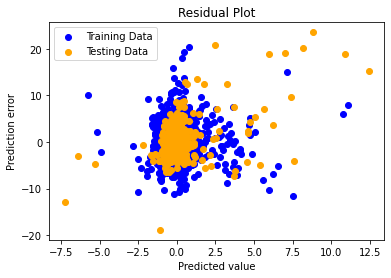

In [92]:
# Plot the Residuals for the Training and Testing data

### BEGIN SOLUTION
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
# plt.hlines(y=0, xmin=y_train.min(), xmax=y_train.max())
plt.title("Residual Plot")
plt.xlabel("Predicted value")
plt.ylabel("Prediction error")
plt.show()
### END SOLUTION